# Function interpolation - simulation study 

This notebook runs a simple simulation study comparing the performance of several multidimensional interpolation methods.

Ultimately, the goal is to implement interpolation methods in *respy*, an open-source Python package for the estimation of dynamic discrete-choice models.

# Motivation



In their 1994 paper, Keane and Wolpin propose an algorithm to effectively reduce the required number of Monte-Carlo integrations for solving a dynamic discrete choice model. Their approach aims at the calculation of continuation values in the backward induction solution algorithm. They propose to solve for the continuation values using Monte-Carlo methods only for a subset of points in the state space and then to interpolate the continuation values on the remaining points. They initially propose to run a regression using information on conditional continuation values. In doing so, they do not exploit information on the underlying state space in the sense that the values of the state variables at a given point of the state space do not enter the calculation. An alternative approach, thus, is to interpret the expected continuation value as a function of all state variables and interpolate directly on the high-dimensional state space. High-dimensional interpolation is less straight-forward than the univariate case and in recent years, a variety of methods has emerged. This study strives to present and compare a selection of these methods.

# Framework for the study

For this study, two test functions have been selected - one motivated by an engineering appliation (the borehole function) and one function specifically designed for testing numerical methods (the Zhou (1998) function). Both functions have been taken from Surjanov & Bingham (2013).

The Borehole function models water flow through a borehole. It models the water flow rate, in $m^3 / yr$ as a function of eight input factors:

$$ f(x) = \frac{2 \pi T_u (H_u - H_l)}{\ln(r / r_w) (1+\frac{2 L T_u}{\ln(r / r_w) r_w^2 K_w}  + \frac{T_u}{T_l} } $$
    
where variables and standard domains are

* $r_w \in [0.05, 0.15]$: radius of borehole ($m$)
* $r \in [100, 50000]$: radius of influence ($m$)
* $T_u \in [63070, 115600]$: transmissivity of upper aquifer ($m^2 / yr$)
* $H_u \in [990, 1110]$: potentiometric head of upper aquifer ($m$)
* $T_l \in [63.1, 116]$: transmissivity of lower aquifer ($m^2 / yr$)
* $H_l \in [700, 820]$: potentiometric head of lower aquifer ($m$)
* $L \in [1120, 1680]$: length of borehole ($m$)
* $K_w \in [9855, 12045]$: hydraulic conductivity of borehole ($m / yr$)

Varying only the first two input arguments ($r_w$ and $r$) and keeping all other variables fixed at the mid point of their respective domain, the function obtains the following shape:

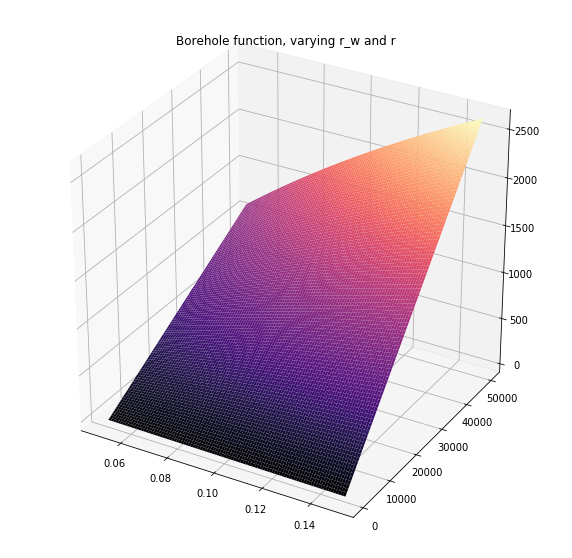

In [1]:
%load_ext autoreload
%matplotlib inline

import os
import sys

root = os.path.dirname(os.path.abspath(sys.argv[0]))
sys.path.insert(0, root)

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import src.functions_to_approximate as functions


x = np.linspace(0.05, 0.15, 100)
y = np.linspace(100, 50000, 100)
X, Y = np.meshgrid(x,y)

grid = np.asarray([X.reshape(10000), Y.reshape(10000)]).T
f_2 = functions.borehole_wrapper_vectorize(grid)
f_2 = np.asarray(f_2).reshape((100, 100))

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d',title="Borehole function, varying r_w and r")
ax.plot_surface(X, Y, f_2, rstride=1, cstride=1, cmap=plt.cm.magma)

The Zhou function is considered by Zhou (1998) for the numerical integration of spiky functions. It has been pointed out in the literature that this function is such that there is no reason to expect it to be approximately a low-order polynomial. The function is defined for an arbitrary number of dimensions $d$:

$$ f(x) = \frac{10^d}{2} [\phi(10(x-\frac{1}{3})) + \phi(10(x-\frac{2}{3}))]$$
with
$$ \phi(z) = (2\pi)^{-0.5 d} \exp(-0.5 {\| z \|}^2)$$

The Zhou function is defined on the domain $[0, 1]^d$. For $d=2$, the function takes on the following shape:

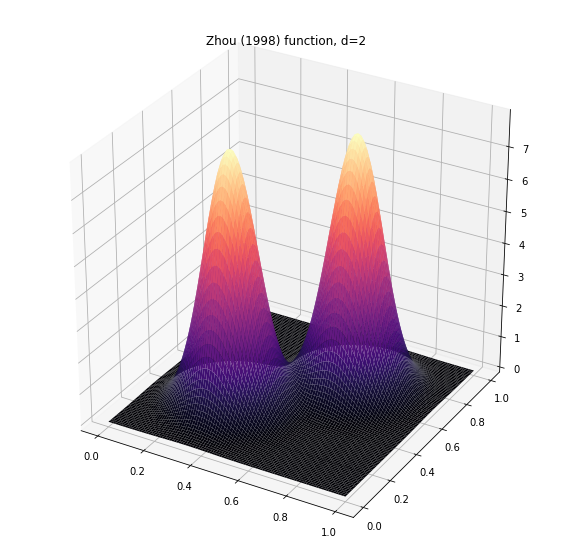

In [2]:
x = y = np.linspace(0.0, 1.0, 100)
X, Y = np.meshgrid(x,y)

grid = np.asarray([X.reshape(10000), Y.reshape(10000)]).T
f_2 = functions.zhou_vectorize(grid)
f_2 = np.asarray(f_2).reshape((100, 100))

fig = plt.figure(figsize=(10, 10))

ax = fig.add_subplot(111, projection='3d',title="Zhou (1998) function, d=2")
ax.plot_surface(X, Y, f_2, rstride=1, cstride=1, cmap=plt.cm.magma)


The code is set up flexibly such that alternative target functions can easily be implemented and analysed. 

# Basic code framework and benchmark analysis

In this section, the basic functions and parameter files used to run the code are introduced and demonstrated by running an example with linear interpolation on a regular grid.

## Import necessary packages:

In [3]:
%load_ext autoreload
%matplotlib inline

import copy
import json
import os
import pdb  # noqa:F401
import pickle
import sys

root = os.path.dirname(os.path.abspath(sys.argv[0]))
sys.path.insert(0, root)

import matplotlib.pyplot as plt
import numpy as np
import src.interpolate as interpolators
import src.functions_to_approximate as functions

from mpl_toolkits.mplot3d import Axes3D
from src.auxiliary import get_grid
from src.auxiliary import get_interpolation_points
from src.auxiliary import rmse as root_mean_squared_error
from main import execute_study
from main import plot_results
from main import compare_results
from main import compare_fit_2d_iter
from time import time

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load default parameters

Default parameters are stored in json-files:

* Default parameters for running the simulation routine: ./src/study_params.json
* Default parameters for the interpolation functions: ./src/interp_params.json 

In [4]:
# load default interpolation parameters
with open("./src/interp_params.json") as json_file:
    interp_params = json.load(json_file)

# load default study parameters
with open("./src/study_params.json") as json_file:
    params_default = json.load(json_file)

study_params.json stores information on:
* controls
    - interpolation method: "linear", "spline", "smolyak", "sparse"
    - grid method (currently only relevant for linear interpolation): "regular", "sparse"
    - evaluate off-grid: "True", "False" (indicator, whether off-grid function values are interpolated)
    - dims: list of dimensions to contain in run
    - iterations: length of vector of iterable for study (interpolation points or sparse grid level) 
    - function to approximate: "borehole_readable", "borehole_wrapper_vectorize", "borehole_wrapper_iter", "zhou_readable", "zhou_vectorize"
* grid
    - lower bounds (by function family, i.e. "borehole" or "zhou": list of lower bounds of the domain of the function
    - upper bounds (by function family, i.e. "borehole" or "zhou": list of upper bounds of the domain of the function
    - orders: (by grid density) list of number of grid points by dimension 
* interpolation method specific parameters (mostly for the mechanics, i.e. don't need to be adjusted)
    - interpolator name
    - iterable (interpolation points or sparse grid levels
    
    
interp_params.json stores settings for the interpolation methods:

* linear
    - grid method: "regular", "sparse"
    - evaluate off-grid: "True", "False" (indicator, whether off-grid function values are interpolated)
    - sparse grid level: number of levels for sparse grid
    - interpolation points: number of points per dimension for interpolation grid 3
* smolyak
    - evaluate off-grid: "True", "False"
    - sparse grid level: number of levels for sparse grid
* spline
    - interpolation points": 3
* sparse
    - polynomial family: "CC", "CH" (selection between Clenshaw-Curtis and Chebychev polynomials)
    - sparse grid level: number of levels for sparse grid

## Benchmark: Simple multi-linear interpolation 

For the multi-linear method, I use the LinearNDInterpolator from Scipy.Interpolate. The interpolator conducts a piecewise linear interpolation in N dimensions by triangulating the input data, and on each triangle performing linear barycentric interpolation. The main advantage of the method is that an arbitrary grid can be used as interpolation basis. To assess the performance of the interpolator, I vary the number of input dimensions for the function to interpolate (starting from 2) and iterate over finer and finer grids, i.e. construct a regular (i.e. evenly spaced) grid with increasing density. All runs are then compared based on the root mean squared error assessed at 1000 randomly chosen points in the state space.

### Set parameters

In [5]:
# create instance for linear regular parametrization and set parameters
params_linear_regular = copy.deepcopy(params_default)
params_linear_regular["controls"]["interpolation method"] = "linear"
params_linear_regular["controls"]["grid_method"] = "regular"
params_linear_regular["controls"]["evaluate off-grid"] = "True"
params_linear_regular["controls"]["iterations"] = 5
params_linear_regular["controls"]["grid density"] = "medium"

try: 
    if os.environ['TRAVIS']:
        params_linear_regular["controls"]["dims"] = [2, 3, 4]
except:
    params_linear_regular["controls"]["dims"] = [2, 3]
    

# create instance for zhou function
params_zhou_linear_regular = copy.deepcopy(params_linear_regular)
params_zhou_linear_regular["controls"]["function to approximate"] = "zhou_vectorize"

# create instance for borehole function
params_borehole_linear_regular = copy.deepcopy(params_linear_regular)
params_borehole_linear_regular["controls"]["function to approximate"] = "borehole_wrapper_vectorize"


### Execute interpolation

In [6]:
results_zhou_linear_regular = execute_study(params_zhou_linear_regular)
results_borehole_linear_regular = execute_study(params_borehole_linear_regular)

### Plot approximation error

Borehole function:

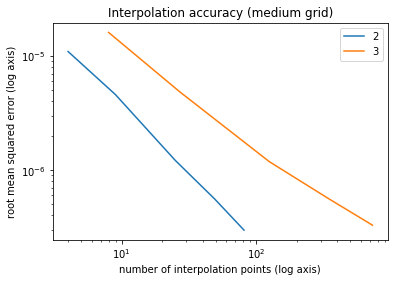

In [7]:
# plot results
plot_results(results_borehole_linear_regular, params_borehole_linear_regular)

Zhou function:

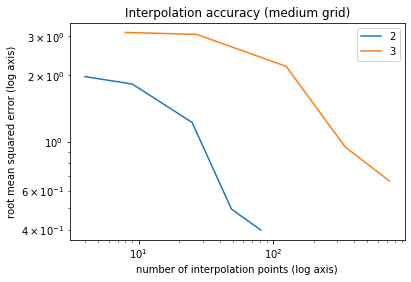

In [8]:
# plot results
plot_results(results_zhou_linear_regular, params_zhou_linear_regular)

Not surprisingly, interpolation accuracy increases with the density of the interpolation grid. Clearly, runtimes increase when adding more points in the construction of the interpolator

In [9]:
# print runtimes
print("runtimes borehole:")
print(results_borehole_linear_regular["runtime"])
print("runtimes zhou:")
print(results_zhou_linear_regular["runtime"])

runtimes borehole:
{2: array([0.00801349, 0.00794744, 0.00801849, 0.00893259, 0.00797868]), 3: array([0.00992203, 0.01495862, 0.0209446 , 0.05087662, 0.11174154])}
runtimes zhou:
{2: array([0.00893617, 0.00701666, 0.0059917 , 0.00797057, 0.00798035]), 3: array([0.00997257, 0.00991273, 0.02097869, 0.04886985, 0.10867596])}


iteration: 0
grid method: regular
total number of interpolation points: 4
runtime for interpolation: 0.01200556755065918
root mean squared error: 1.9751962194798462


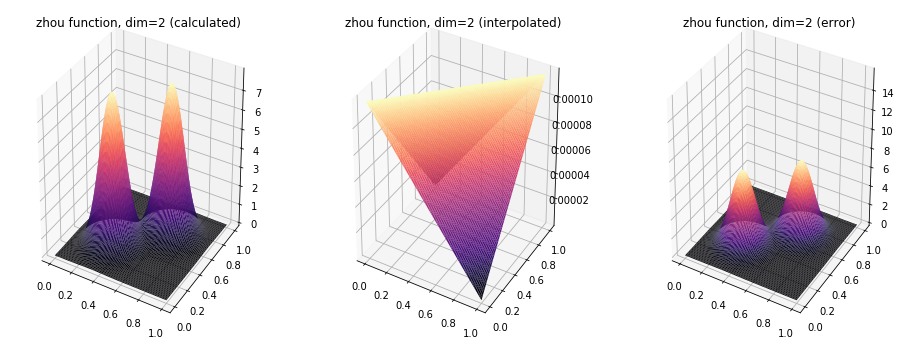

----------------------------------------------------
iteration: 1
grid method: regular
total number of interpolation points: 9
runtime for interpolation: 0.010971784591674805
root mean squared error: 1.826823125714936


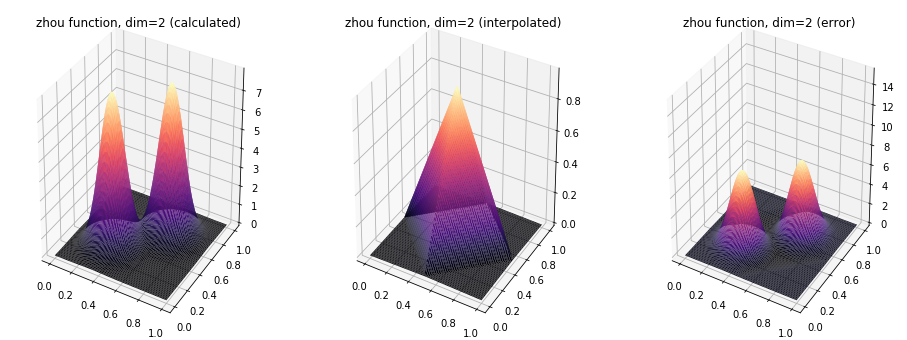

----------------------------------------------------
iteration: 2
grid method: regular
total number of interpolation points: 25
runtime for interpolation: 0.010973453521728516
root mean squared error: 1.2245353506751067


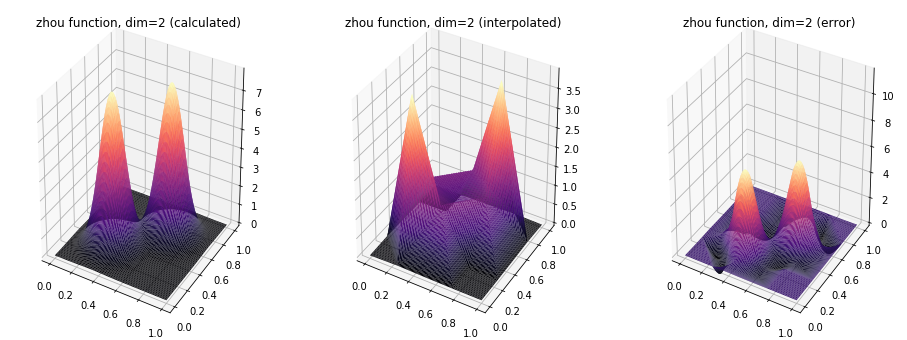

----------------------------------------------------
iteration: 3
grid method: regular
total number of interpolation points: 49
runtime for interpolation: 0.008976221084594727
root mean squared error: 0.4961820465494429


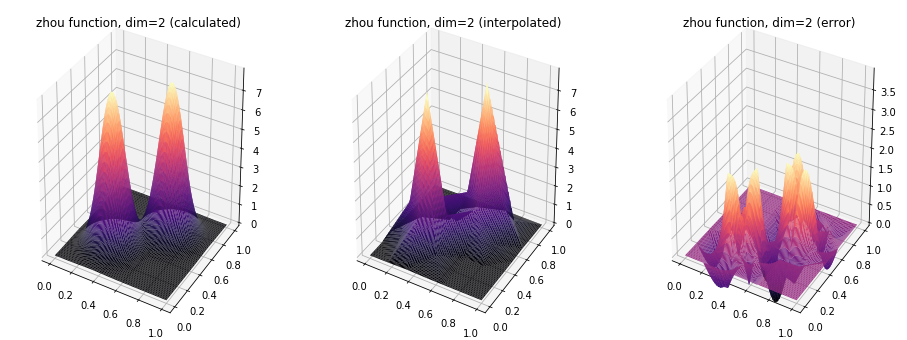

----------------------------------------------------
iteration: 4
grid method: regular
total number of interpolation points: 81
runtime for interpolation: 0.010009765625
root mean squared error: 0.3985551304867043


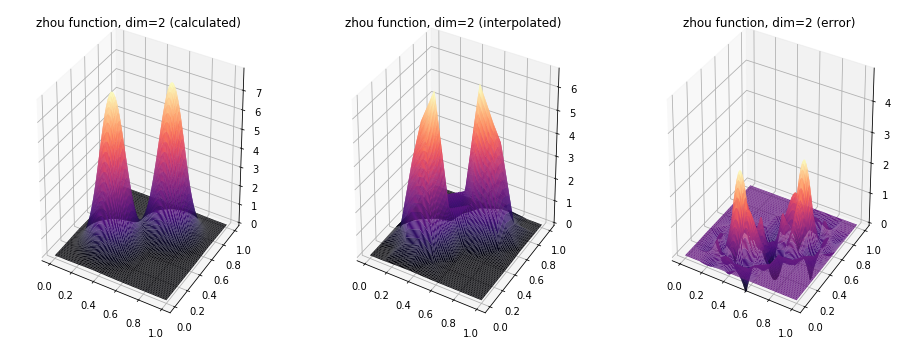

----------------------------------------------------
iteration: 5
grid method: regular
total number of interpolation points: 121
runtime for interpolation: 0.011014223098754883
root mean squared error: 0.25605569126473693


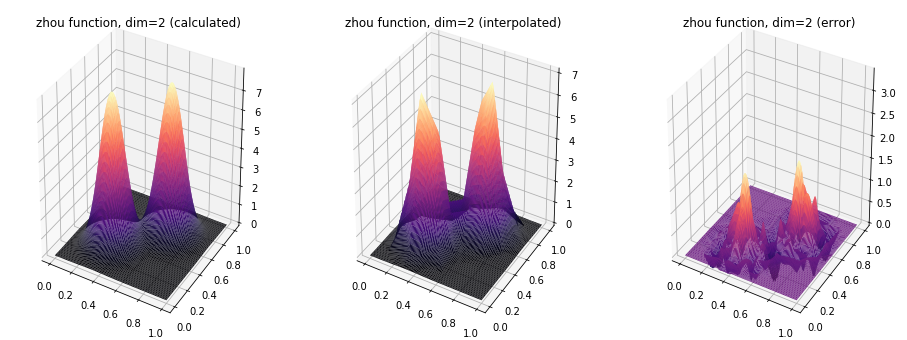

----------------------------------------------------
iteration: 6
grid method: regular
total number of interpolation points: 169
runtime for interpolation: 0.01096963882446289
root mean squared error: 0.1700267803606926


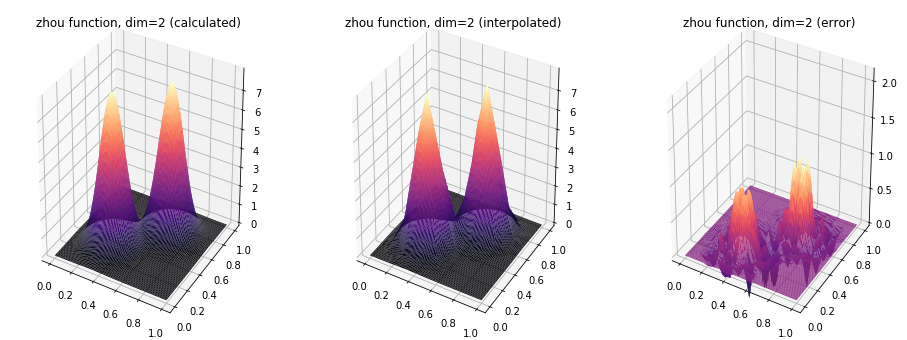

----------------------------------------------------
iteration: 7
grid method: regular
total number of interpolation points: 225
runtime for interpolation: 0.011966943740844727
root mean squared error: 0.135018005069548


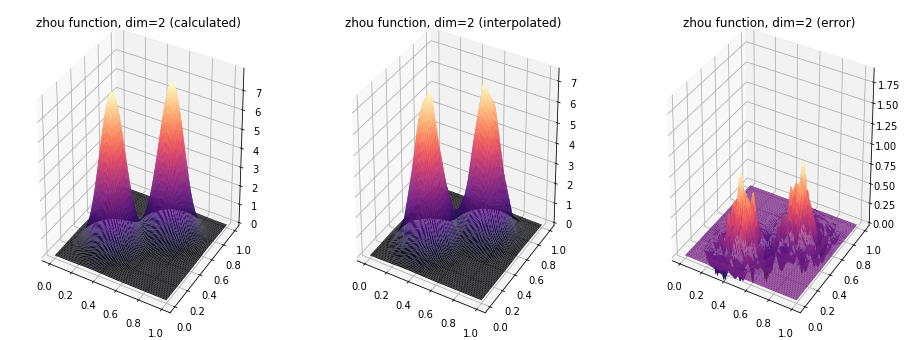

----------------------------------------------------
iteration: 8
grid method: regular
total number of interpolation points: 625
runtime for interpolation: 0.01795172691345215
root mean squared error: 0.04653995932939058


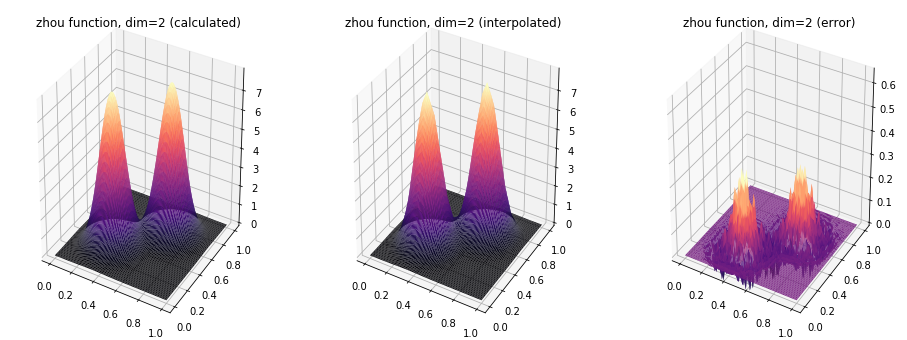

----------------------------------------------------


In [10]:
params_zhou_fit_linear = copy.deepcopy(params_zhou_linear_regular)
iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8]

for iteration in iterations:
    print(f"iteration: {iteration}")
    compare_fit_2d_iter(params_zhou_fit_linear, iteration)


# Alternative methods

Next, I consider a number of alternative interpolation methods. 

## Spline interpolation

In [11]:
# create instance for linear regular parametrization and set parameters
params_spline = copy.deepcopy(params_default)
params_spline["controls"]["interpolation method"] = "spline"
params_spline["controls"]["grid_method"] = "regular"
params_spline["controls"]["evaluate off-grid"] = "True"
params_spline["controls"]["iterations"] = 5
params_spline["controls"]["grid density"] = "medium"

try: 
    if os.environ['TRAVIS']:
        params_linear_regular["controls"]["dims"] = [2, 3, 4]
except:
    params_linear_regular["controls"]["dims"] = [2, 3]

# create instance for zhou function
params_zhou_spline = copy.deepcopy(params_spline)
params_zhou_spline["controls"]["function to approximate"] = "zhou_vectorize"

# create instance for borehole function
params_borehole_spline = copy.deepcopy(params_spline)
params_borehole_spline["controls"]["function to approximate"] = "borehole_wrapper_vectorize"

In [12]:
results_zhou_spline = execute_study(params_zhou_spline)
results_borehole_spline = execute_study(params_borehole_spline)

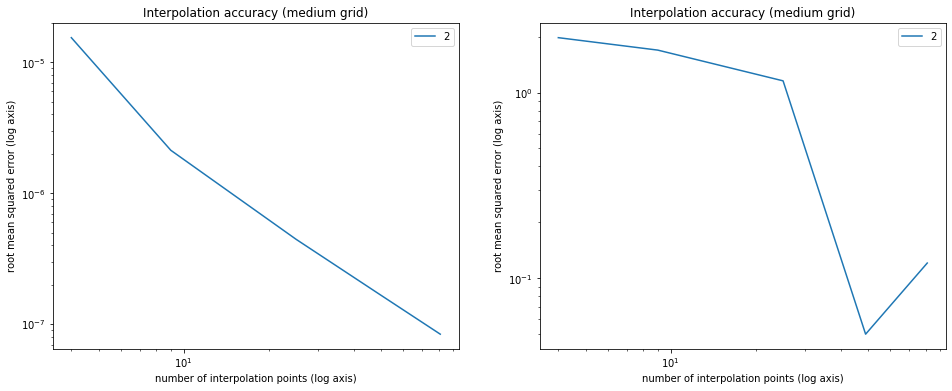

In [13]:
fig = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plot_legend = []
plot_x = []
plot_y = []
for dims in params_borehole_spline["controls"]["dims"]:
    plot_legend.append(dims)
    plot_x.append(results_borehole_spline["gridpoints"][dims])
    plot_y.append(results_borehole_spline["rmse"][dims])

for idx in range(len(params_borehole_spline["controls"]["dims"])):
    plt.plot(plot_x[idx], plot_y[idx])

plt.xscale("log")
plt.yscale("log")
plt.xlabel("number of interpolation points (log axis)")
plt.ylabel("root mean squared error (log axis)")
plt.legend(plot_legend)
plt.title(
    "Interpolation accuracy (" + params_borehole_spline["controls"]["grid density"] + " grid)"
)

plt.subplot(1, 2, 2)
plot_legend = []
plot_x = []
plot_y = []
for dims in params_zhou_spline["controls"]["dims"]:
    plot_legend.append(dims)
    plot_x.append(results_zhou_spline["gridpoints"][dims])
    plot_y.append(results_zhou_spline["rmse"][dims])

for idx in range(len(params_zhou_spline["controls"]["dims"])):
    plt.plot(plot_x[idx], plot_y[idx])

plt.xscale("log")
plt.yscale("log")
plt.xlabel("number of interpolation points (log axis)")
plt.ylabel("root mean squared error (log axis)")
plt.legend(plot_legend)
plt.title(
    "Interpolation accuracy (" + params_zhou_spline["controls"]["grid density"] + " grid)"
)

plt.show()


iteration: 0
grid method: regular
total number of interpolation points: 4
runtime for interpolation: 2.4412758350372314
root mean squared error: 1.9752153045094114


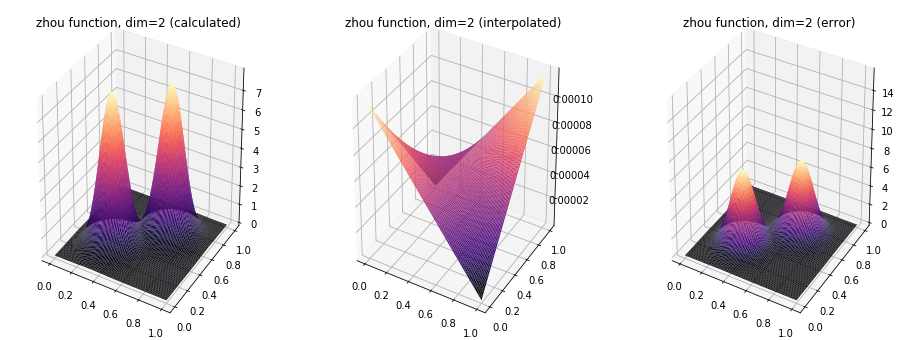

----------------------------------------------------
iteration: 1
grid method: regular
total number of interpolation points: 9
runtime for interpolation: 0.003987789154052734
root mean squared error: 1.6928364572226835


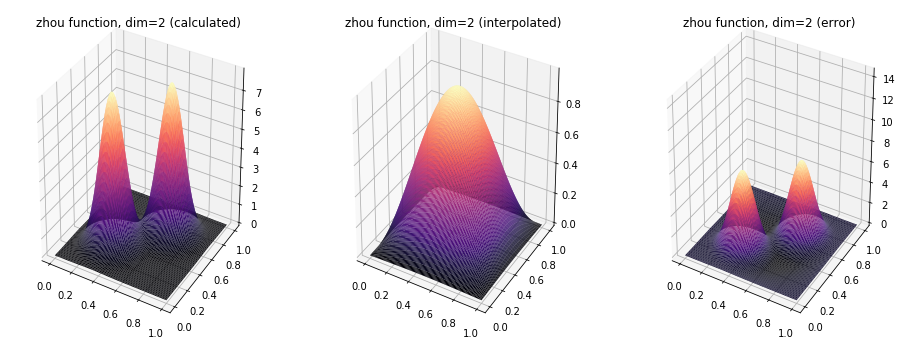

----------------------------------------------------
iteration: 2
grid method: regular
total number of interpolation points: 25
runtime for interpolation: 0.0030257701873779297
root mean squared error: 1.156414578623518


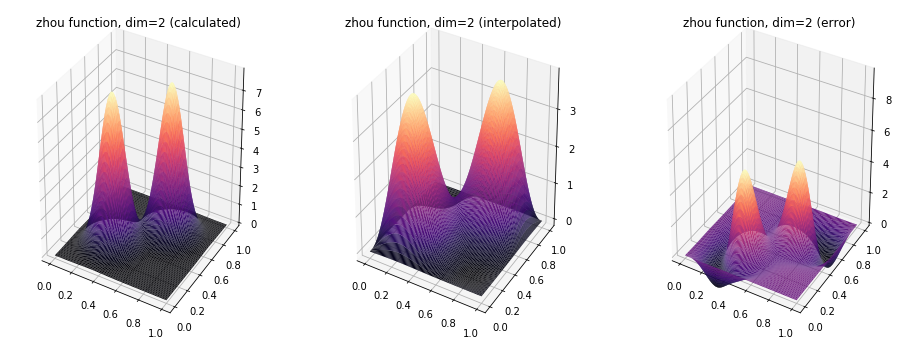

----------------------------------------------------
iteration: 3
grid method: regular
total number of interpolation points: 49
runtime for interpolation: 0.0029914379119873047
root mean squared error: 0.050007844188242244


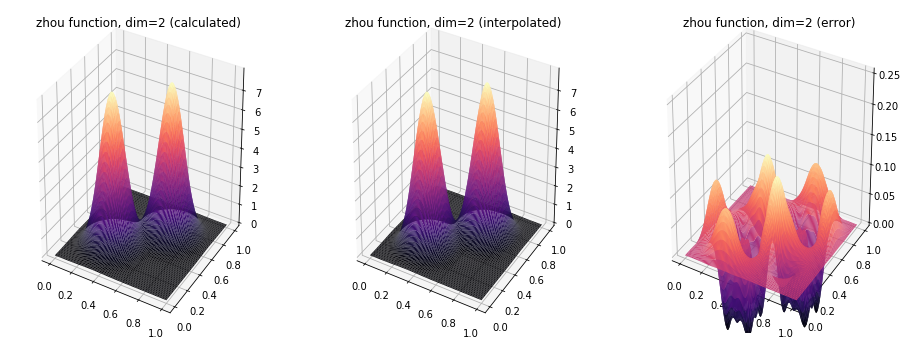

----------------------------------------------------
iteration: 4
grid method: regular
total number of interpolation points: 81
runtime for interpolation: 0.003988981246948242
root mean squared error: 0.12079856294857587


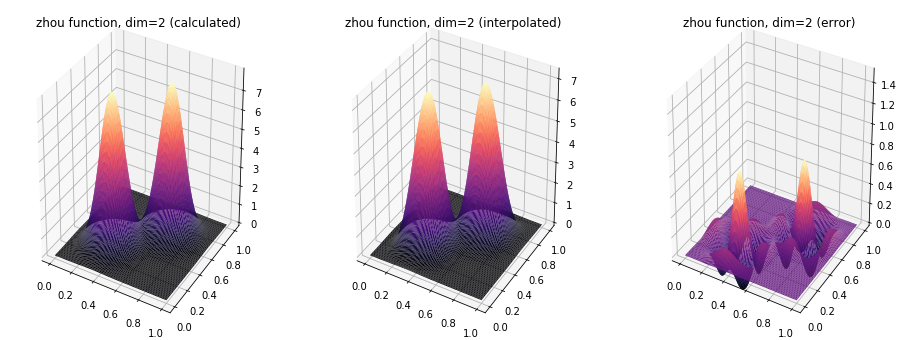

----------------------------------------------------
iteration: 5
grid method: regular
total number of interpolation points: 121
runtime for interpolation: 0.0039865970611572266
root mean squared error: 0.035804660027256574


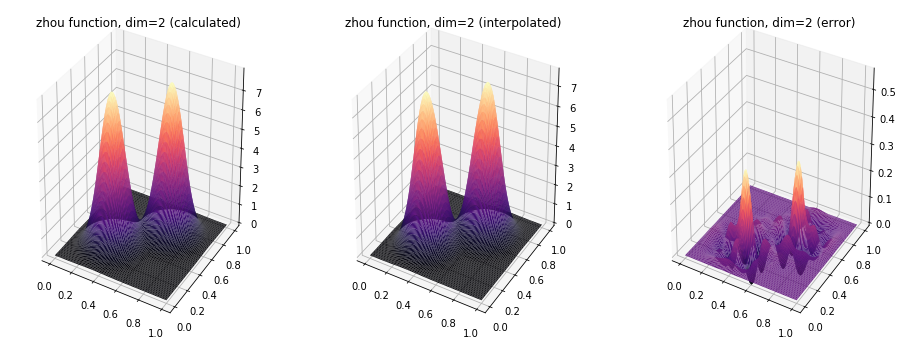

----------------------------------------------------
iteration: 6
grid method: regular
total number of interpolation points: 169
runtime for interpolation: 0.003942966461181641
root mean squared error: 0.01278074396837842


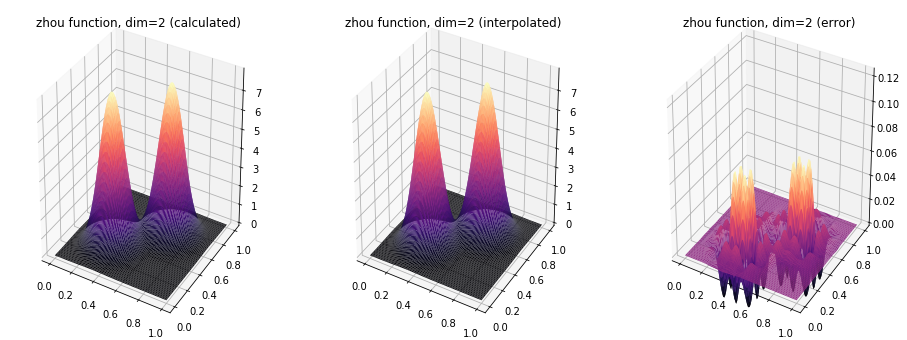

----------------------------------------------------
iteration: 7
grid method: regular
total number of interpolation points: 225
runtime for interpolation: 0.0029904842376708984
root mean squared error: 0.006152743242768087


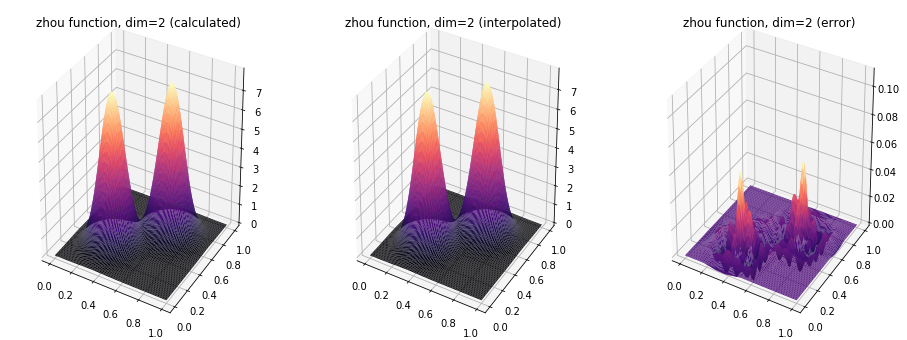

----------------------------------------------------
iteration: 8
grid method: regular
total number of interpolation points: 625
runtime for interpolation: 0.003988981246948242
root mean squared error: 0.0005429244376313625


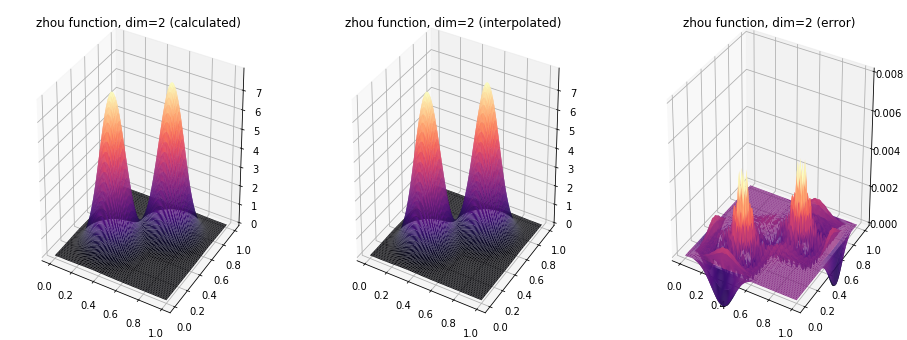

----------------------------------------------------


In [14]:
params_zhou_fit_spline = copy.deepcopy(params_zhou_spline)
iterations = [0, 1, 2, 3, 4, 5, 6, 7, 8]

for iteration in iterations:
    print(f"iteration: {iteration}")
    compare_fit_2d_iter(params_zhou_fit_spline, iteration)


## Smolyak sparse grid interpolation

For the final method I tested, I again used the dolo package. The interpolator used here is dolo.numeric.interpolation.smolyak. 

In [15]:
# create instance for linear regular parametrization and set parameters
params_smolyak = copy.deepcopy(params_default)
params_smolyak["controls"]["interpolation method"] = "smolyak"
params_smolyak["controls"]["grid_method"] = "sparse"
params_smolyak["controls"]["evaluate off-grid"] = "True"
params_smolyak["controls"]["iterations"] = 3
params_smolyak["controls"]["grid density"] = "medium"

try: 
    if os.environ['TRAVIS']:
        params_linear_regular["controls"]["dims"] = [2, 3]
except:
    params_linear_regular["controls"]["dims"] = [2, 3, 4]


# create instance for zhou function
params_zhou_smolyak = copy.deepcopy(params_smolyak)
params_zhou_smolyak["controls"]["function to approximate"] = "zhou_vectorize"

# create instance for borehole function
params_borehole_smolyak = copy.deepcopy(params_smolyak)
params_borehole_smolyak["controls"]["function to approximate"] = "borehole_wrapper_vectorize"

In [16]:
results_zhou_smolyak = execute_study(params_zhou_smolyak)
results_borehole_smolyak = execute_study(params_borehole_smolyak)

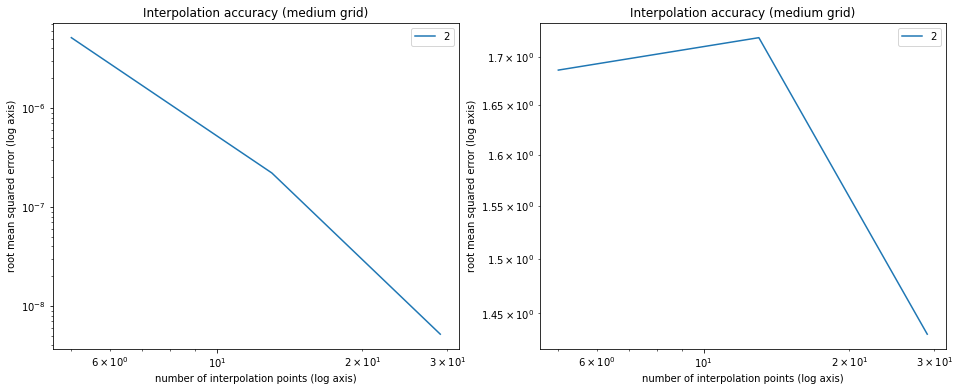

In [17]:
fig = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plot_legend = []
plot_x = []
plot_y = []
for dims in params_borehole_smolyak["controls"]["dims"]:
    plot_legend.append(dims)
    plot_x.append(results_borehole_smolyak["gridpoints"][dims])
    plot_y.append(results_borehole_smolyak["rmse"][dims])

for idx in range(len(params_borehole_smolyak["controls"]["dims"])):
    plt.plot(plot_x[idx], plot_y[idx])

plt.xscale("log")
plt.yscale("log")
plt.xlabel("number of interpolation points (log axis)")
plt.ylabel("root mean squared error (log axis)")
plt.legend(plot_legend)
plt.title(
    "Interpolation accuracy (" + params_borehole_smolyak["controls"]["grid density"] + " grid)"
)

plt.subplot(1, 2, 2)
plot_legend = []
plot_x = []
plot_y = []
for dims in params_zhou_smolyak["controls"]["dims"]:
    plot_legend.append(dims)
    plot_x.append(results_zhou_smolyak["gridpoints"][dims])
    plot_y.append(results_zhou_smolyak["rmse"][dims])

for idx in range(len(params_zhou_smolyak["controls"]["dims"])):
    plt.plot(plot_x[idx], plot_y[idx])

plt.xscale("log")
plt.yscale("log")
plt.xlabel("number of interpolation points (log axis)")
plt.ylabel("root mean squared error (log axis)")
plt.legend(plot_legend)
plt.title(
    "Interpolation accuracy (" + params_zhou_smolyak["controls"]["grid density"] + " grid)"
)

plt.show()


iteration: 0
grid method: regular
total number of interpolation points: 5
runtime for interpolation: 0.0010018348693847656
root mean squared error: 1.6858871505140047


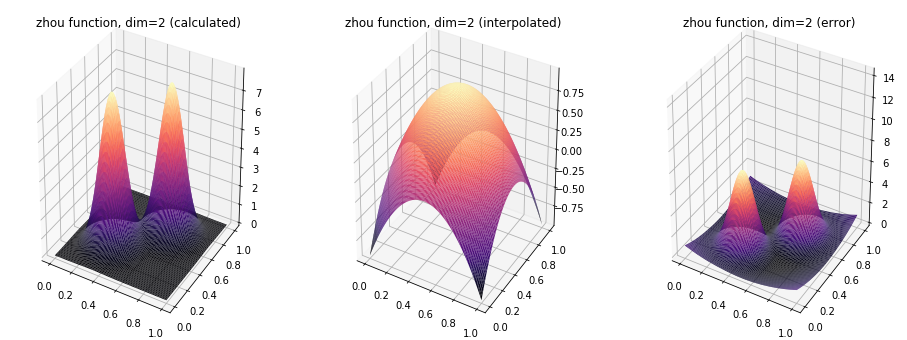

----------------------------------------------------
iteration: 1
grid method: regular
total number of interpolation points: 13
runtime for interpolation: 0.002028226852416992
root mean squared error: 1.7200906422390565


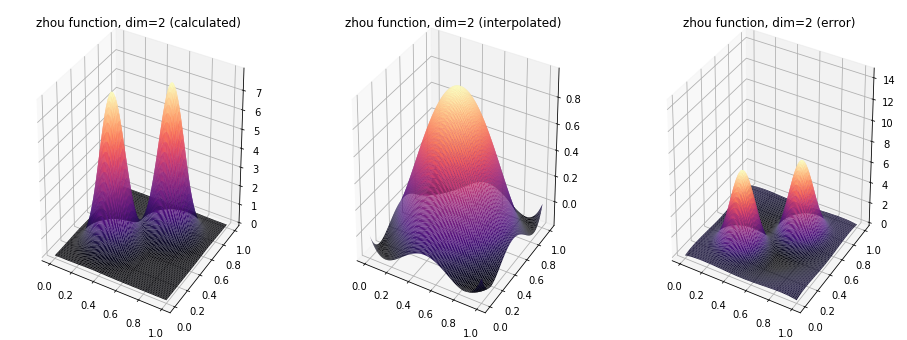

----------------------------------------------------
iteration: 2
grid method: regular
total number of interpolation points: 29
runtime for interpolation: 0.003951549530029297
root mean squared error: 1.4315442351674423


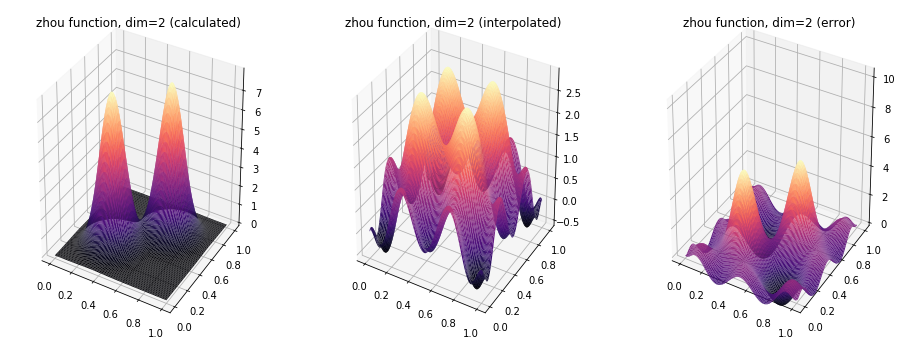

----------------------------------------------------


In [18]:
params_zhou_fit_smolyak = copy.deepcopy(params_zhou_smolyak)
iterations = [0, 1, 2]

for iteration in iterations:
    print(f"iteration: {iteration}")
    compare_fit_2d_iter(params_zhou_fit_smolyak, iteration)


## Sparse grid interpolation

In [19]:
# create instance for linear regular parametrization and set parameters
params_sparse = copy.deepcopy(params_default)
params_sparse["controls"]["interpolation method"] = "sparse"
params_sparse["controls"]["grid_method"] = "sparse"
params_sparse["controls"]["evaluate off-grid"] = "True"
params_sparse["controls"]["iterations"] = 5
params_sparse["controls"]["grid density"] = "medium"

try: 
    if os.environ['TRAVIS']:
        params_linear_regular["controls"]["dims"] = [2]
except:
    params_linear_regular["controls"]["dims"] = [2]


# create instance for zhou function
params_zhou_sparse = copy.deepcopy(params_sparse)
params_zhou_sparse["controls"]["function to approximate"] = "zhou_vectorize"

# create instance for borehole function
params_borehole_sparse = copy.deepcopy(params_sparse)
params_borehole_sparse["controls"]["function to approximate"] = "borehole_wrapper_vectorize"

In [20]:
results_zhou_sparse = execute_study(params_zhou_sparse)
results_borehole_sparse = execute_study(params_borehole_sparse)

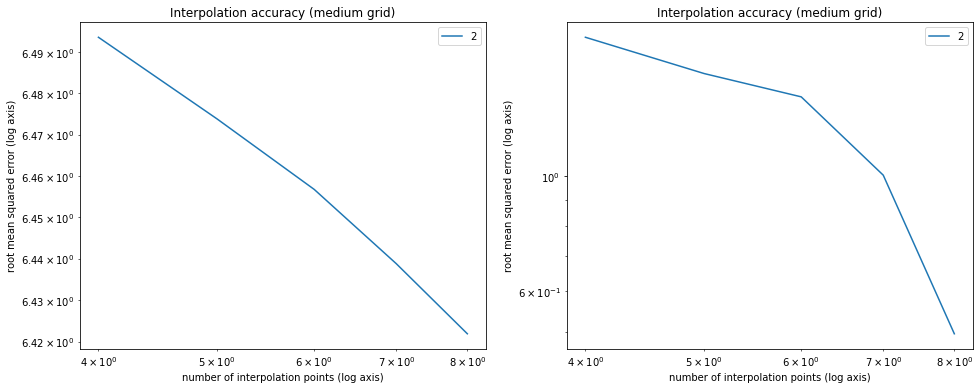

In [21]:
fig = plt.figure(figsize=(16, 6))

plt.subplot(1, 2, 1)
plot_legend = []
plot_x = []
plot_y = []
for dims in params_borehole_sparse["controls"]["dims"]:
    plot_legend.append(dims)
    plot_x.append(results_borehole_sparse["gridpoints"][dims])
    plot_y.append(results_borehole_sparse["rmse"][dims])

for idx in range(len(params_borehole_sparse["controls"]["dims"])):
    plt.plot(plot_x[idx], plot_y[idx])

plt.xscale("log")
plt.yscale("log")
plt.xlabel("number of interpolation points (log axis)")
plt.ylabel("root mean squared error (log axis)")
plt.legend(plot_legend)
plt.title(
    "Interpolation accuracy (" + params_borehole_sparse["controls"]["grid density"] + " grid)"
)

plt.subplot(1, 2, 2)
plot_legend = []
plot_x = []
plot_y = []
for dims in params_zhou_spline["controls"]["dims"]:
    plot_legend.append(dims)
    plot_x.append(results_zhou_sparse["gridpoints"][dims])
    plot_y.append(results_zhou_sparse["rmse"][dims])

for idx in range(len(params_zhou_sparse["controls"]["dims"])):
    plt.plot(plot_x[idx], plot_y[idx])

plt.xscale("log")
plt.yscale("log")
plt.xlabel("number of interpolation points (log axis)")
plt.ylabel("root mean squared error (log axis)")
plt.legend(plot_legend)
plt.title(
    "Interpolation accuracy (" + params_zhou_sparse["controls"]["grid density"] + " grid)"
)

plt.show()


iteration: 0
grid method: regular
total number of interpolation points: 4
runtime for interpolation: 1.0690557956695557
root mean squared error: 1.8574489676572299


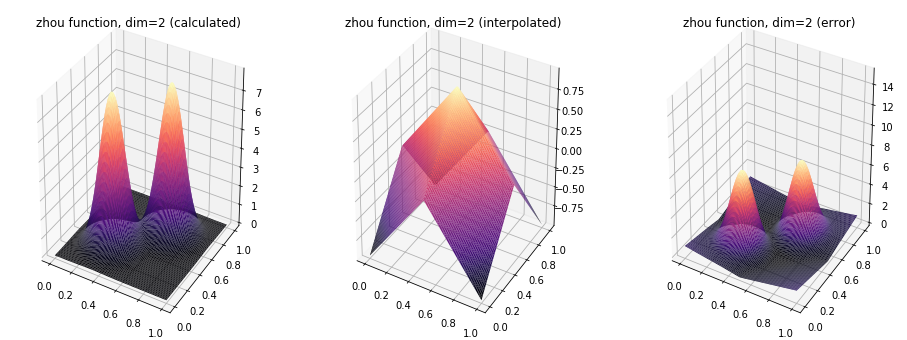

----------------------------------------------------
iteration: 1
grid method: regular
total number of interpolation points: 5
runtime for interpolation: 4.580484628677368
root mean squared error: 1.5801514212334968


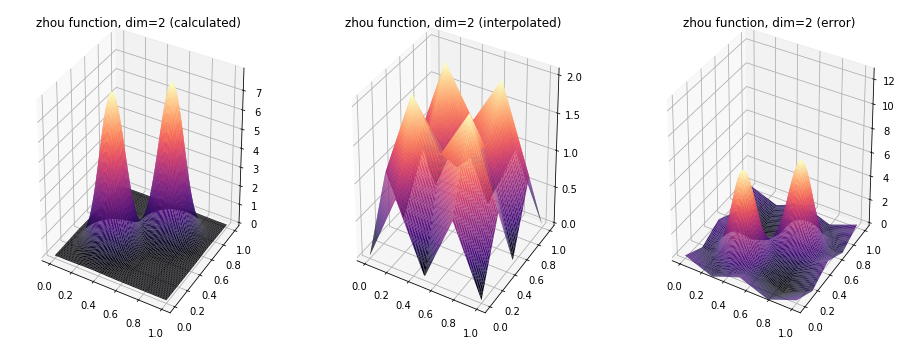

----------------------------------------------------
iteration: 2
grid method: regular
total number of interpolation points: 6
runtime for interpolation: 12.294663429260254
root mean squared error: 1.4243901260811693


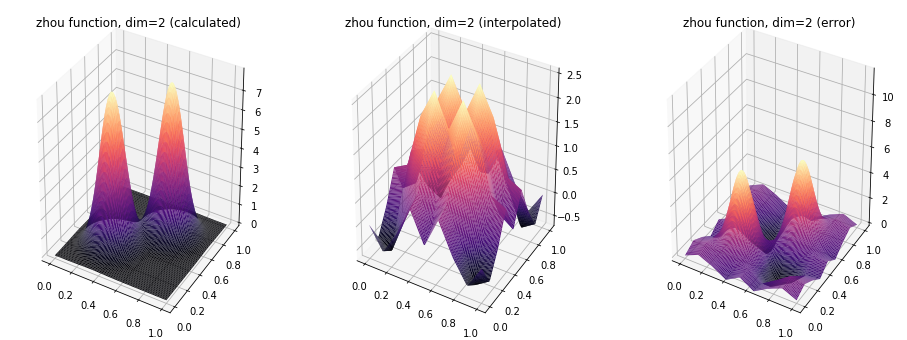

----------------------------------------------------
iteration: 3
grid method: regular
total number of interpolation points: 7
runtime for interpolation: 30.84722399711609
root mean squared error: 1.0047988238836818


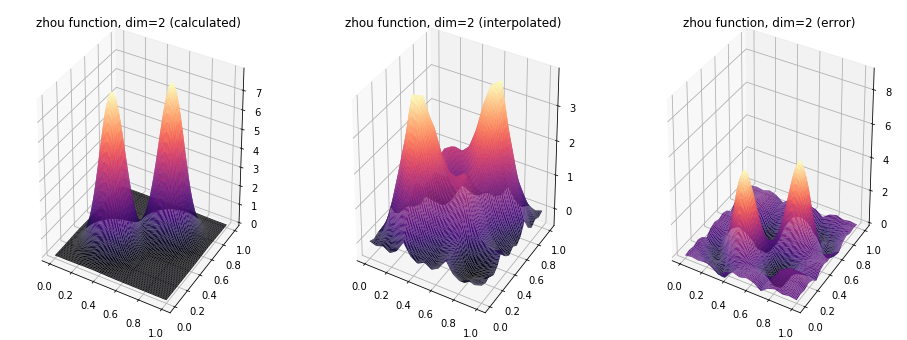

----------------------------------------------------
iteration: 4
grid method: regular
total number of interpolation points: 8
runtime for interpolation: 78.55060887336731
root mean squared error: 0.4956595504905783


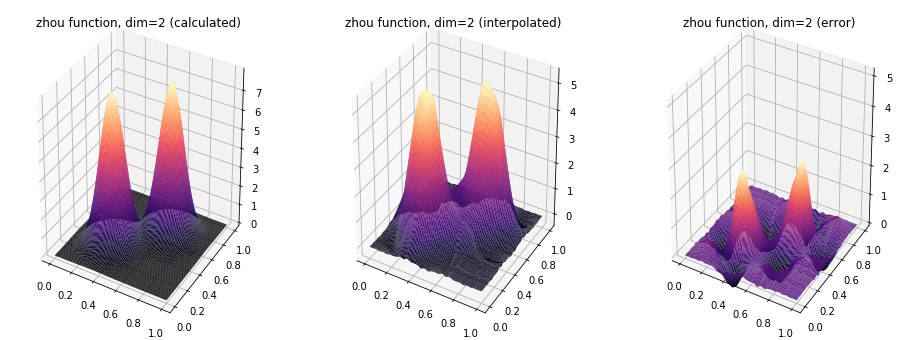

----------------------------------------------------
iteration: 5
grid method: regular
total number of interpolation points: 9
runtime for interpolation: 173.5681390762329
root mean squared error: 0.19419247078896415


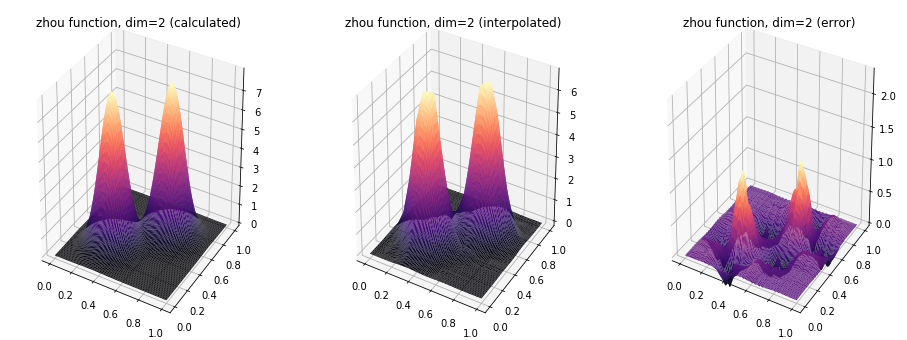

----------------------------------------------------


In [29]:
params_zhou_fit_sparse = copy.deepcopy(params_zhou_sparse)
iterations = [0, 1, 2, 3, 4, 5]

for iteration in iterations:
    print(f"iteration: {iteration}")
    compare_fit_2d_iter(params_zhou_fit_sparse, iteration)


# Adaptations for discrete domains

One major drawback of many powerful interpolation methods such as sparse grid methods is that the grid is determined by the functional family used to construct the interpolant and by the bounds of the domain. 

One way to address this issue is to interpret the discrete variables as categorical variable and construct separate interpolators for the target function conditional on the value of the categorical variable. Suppose, for instance, a d-dimensional function where one variable can only take on the values $[0, 1, 2]$. Then, it would be possible to construct 3 separate (d-1)-dimensional interpolants for the target function given that the value of the discrete variable is $0$, $1$, or $2$, respectively. While inheriting the desirable properties of the sparse method for the conditional interpolants, this approach runs into issues if (i) the discrete variable can take on many values or (ii) more than one of the variables is discrete. In both cases, the number of conditional interpolants quickly becomes infeasibly large.

Another way to address the issue is to assume that the target function is not in fact not defined in between the possible realizations, but the data is such that only a finite set of realizations ever materializes. If, in addition, we assume that the target function is continuous "in between" the discrete realizations of the discrete variable, we can apply interpolation methods to approximate the function values at the sparse grid nodes that are "off-grid".

Clearly, an additional source of approximation error is introduced in doing so. Hence, there now is a trade-off between using a deeper sparse grid to increase the accuracy of the fit and adding error through more "local approximations" of off-grid function values for the sparse grid nodes.

To assess which effect dominates, I compare the approximation error obtained from first applying (local) linear interpolation to approximate function values and then using Smolyak sparse grid interpolation for different orders of the polynomial family (i.e. for different depths of the sparse grid).

In [22]:
# set parameters for off-grid evaluation
params_zhou_smolyak_1stage = copy.deepcopy(params_zhou_smolyak)
params_zhou_smolyak_1stage["controls"]["evaluate off-grid"] = "True"

# set parameters for off-grid interpolation
params_zhou_smolyak_2stage = copy.deepcopy(params_zhou_smolyak)
params_zhou_smolyak_2stage["controls"]["evaluate off-grid"] = "False"

In [23]:
# execute simulation
results_zhou_smolyak_1stage = copy.deepcopy(results_zhou_smolyak)
results_zhou_smolyak_2stage = execute_study(params_zhou_smolyak_2stage)

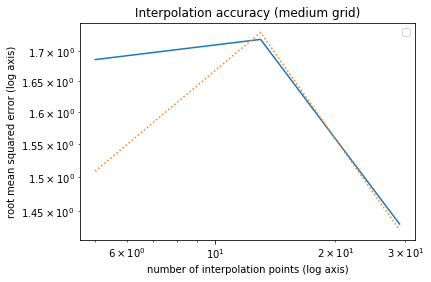

In [24]:
# plot results
compare_results(
    results_zhou_smolyak_1stage, 
    results_zhou_smolyak_2stage, 
    params_zhou_smolyak_1stage, 
    params_zhou_smolyak_2stage
)

As can be seen from the graph, the additional error introduced through the first stage interpolation might outweigh the accuracy gain from adding layers / polynomials in the global interpolation. This effect is mainly driven by the accuracy of the first stage interpolation, which in turn depends on how far, on average, the interpolation nodes are from the global grid points. This can be observed by varying the density of the global grid:

In [25]:
params_zhou_smolyak_1stage_lowdensity = copy.deepcopy(params_zhou_smolyak_1stage)
params_zhou_smolyak_2stage_lowdensity = copy.deepcopy(params_zhou_smolyak_2stage)
params_zhou_smolyak_1stage_highdensity = copy.deepcopy(params_zhou_smolyak_1stage)
params_zhou_smolyak_2stage_highdensity = copy.deepcopy(params_zhou_smolyak_2stage)

params_zhou_smolyak_1stage_lowdensity["controls"]["grid density"] = "low"
params_zhou_smolyak_2stage_lowdensity["controls"]["grid density"] = "low"
params_zhou_smolyak_1stage_highdensity["controls"]["grid density"] = "high"
params_zhou_smolyak_2stage_highdensity["controls"]["grid density"] = "high"

In [26]:
# execute simulation
results_zhou_smolyak_1stage_lowdensity = execute_study(params_zhou_smolyak_1stage_lowdensity)
results_zhou_smolyak_2stage_lowdensity = execute_study(params_zhou_smolyak_2stage_lowdensity)
results_zhou_smolyak_1stage_highdensity = execute_study(params_zhou_smolyak_1stage_highdensity)
results_zhou_smolyak_2stage_highdensity = execute_study(params_zhou_smolyak_2stage_highdensity)

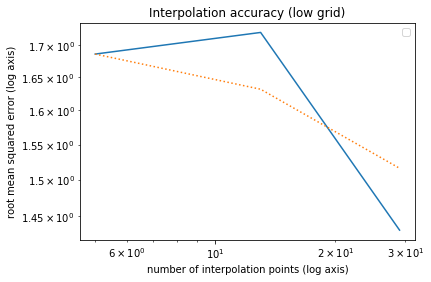

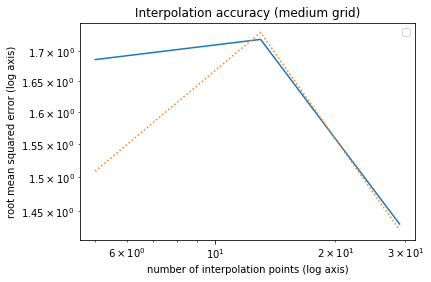

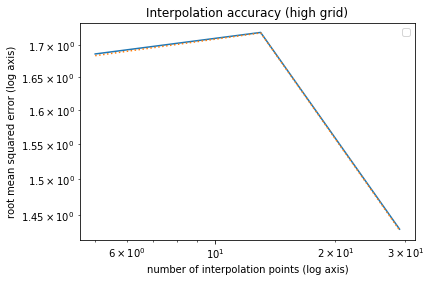

In [27]:
# plot results
compare_results(
    results_zhou_smolyak_1stage_lowdensity, 
    results_zhou_smolyak_2stage_lowdensity, 
    params_zhou_smolyak_1stage_lowdensity, 
    params_zhou_smolyak_2stage_lowdensity
)
compare_results(
    results_zhou_smolyak_1stage, 
    results_zhou_smolyak_2stage, 
    params_zhou_smolyak_1stage, 
    params_zhou_smolyak_2stage
)
compare_results(
    results_zhou_smolyak_1stage_highdensity, 
    results_zhou_smolyak_2stage_highdensity, 
    params_zhou_smolyak_1stage_highdensity, 
    params_zhou_smolyak_2stage_highdensity
)

With increasingly fine grids, the first stage interpolation error vanishes. The issue here, however, is precisely the issue we started with: with discrete variables, we are not free to choose the density of the grid in the respective dimension. Having finer grids in the continuous dimensions still reduces the first stage error. 

In light of this, one potential way to improve upon accuracy and computational performance of sparse grid interpolation on discrete domains is to "endogenize" the grid on the continuous dimensions, i.e. set the grid points in the continuous dimensions in a way that is optimal given the used first stage interpolation method.

Finally, we compare the feasible implementation of a sparse grid method (i.e. smolyak interpolation with linear first stage interpolation of of-grid points) with the benchmark linear interpolation on a regular grid.

KeyError: 3

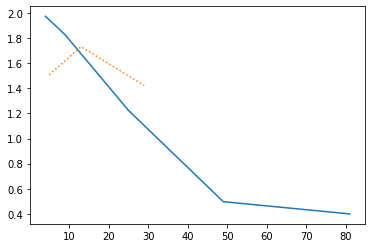

In [28]:
# plot results
compare_results(
    results_zhou_linear_regular, 
    results_zhou_smolyak_2stage, 
    params_zhou_linear_regular, 
    params_zhou_smolyak_2stage
)

# Implementation in respy

To implement any of the methods presented above, some adaptations of / additions to the respy package are required. As respy handles state spaces as indices, functionality to translate input values to indices is required. Some functions with this purpose have been included in the repository (.src/auxiliary.py). In the respy package itself, the functions get_not_interpolated_indicator, get_predictions and solve_with_backward_induction require minor changes to accomodate the new code.

# References

* Keane & Wolpn (1994) to be added.
* Surjanovic, S. & Bingham, D. (2013). Virtual Library of Simulation Experiments: Test Functions and Datasets. Retrieved February 1, 2020, from http://www.sfu.ca/~ssurjano.
* Zhou, Y. (1998). Adaptive importance sampling for integration. Ph.D. Thesis, Stanford University.
